In [142]:
# ARCHIVED - added this code to server scripts?

# last modified May 2023
# created by G Oldford
# purpose: organize tabular CTD stats output from the python analysis package for pub
#          and generate the missing mean and standard dev by vert lev groupings for taylor plot
#
# data in: pickle file with CTD metrics (bias,rmse,skill and raw T&S for mod and obs)
# data out: organized table with metrics above plus mean, stdev and domain tag

# notes: 
#  - pearsons r (correlation coef) and taylors might not be most effective
#     since correlation and R stat are typically used for time series or STT, SSH

In [5]:
import scipy.io
import os
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats

import multiprocessing as mp # for pnts in poly check
pd.set_option('display.max_columns', None)

path1 = "D:/temp_nemo/RUN203_PLOTS_SCORES/"
pic_data = "CTDcast_metrics_hindcast.pickle"

scores_data_ctd = pickle.load(open(os.path.join(path1,pic_data), 'rb'))



# domains
# copied from CTD_analysis_domain_config_template-SalishSea.yml
DiscIsl = np.array([[50,-125.5],
                    [50,-124.25],
                    [50.75,-124.25],
                    [50.75,-126.25],
                    [50.4,-126.25]])

JdF = np.array([[48.4,-123.6], 
                [48.62,-124.7],
                [48.37,-124.7],
                [48.14,-124.],
                [48.1,-123.5],
                [48.,-122.8],
                [48.25,-122.72],
                [48.38,-122.63],
                [48.47,-123.],
                [48.42,-123.32],
                [48.48,-123.46]
               ])

Puget = np.array([[48.5,-122.25],
                  [48.38,-122.63],
                  [48.25,-122.72],
                  [48.,-122.8],
                  [47.,-123.5],
                  [47.,-122.],
                  [48.,-122.]
                 ])

GulfIsl = np.array([[48.47,-123.],
                    [48.38,-122.63],
                    [48.5,-122.25],
                    [48.85,-122.6],
                    [48.7,-122.9],
                    [48.965,-123.53],
                    [49.18,-123.8],
                    [49.2,-124.],
                    [48.4,-123.6],
                    [48.48,-123.46],
                    [48.67,-123.42],
                    [48.67,-123.15]
                   ])
Haro = np.array([[48.47,-123.],
                 [48.67,-123.15],
                 [48.67,-123.42],
                 [48.48,-123.46],
                 [48.42,-123.32]
                ])

SoGN = np.array([[49.34,-123.55], 
                 [49.41,-123.55],
                 [50.,-124.],
                 [50.,-124.5],
                 [50.,-125.4],
                 [49.4,-124.8],
                 [49.2,-124.],
                 [49.18,-123.8]
                ])

SoGS = np.array([[48.7,-122.9],
                 [48.85,-122.6],
                 [49.1,-122.85],
                 [49.3,-123.],
                 [49.35,-123.05],
                 [49.5,-123.1],
                 [49.71,-123.15],
                 [49.53,-123.55],
                 [49.41,-123.55],
                 [49.34,-123.55],
                 [49.18,-123.8],
                 [48.965,-123.53]
                ])

domains = {"DiscIsl": DiscIsl, 
           "JdF": JdF,
          "Puget": Puget,
          "GulfIsl": GulfIsl,
          "Haro": Haro,
          "SoGN": SoGN,
          "SoGS": SoGS}



#scores_data_ctd['SalishSea1500-RUN203']['scores']['Alberni_Inlet_CastCTD_1991-10-28_2025h'].keys()


# tried and failed to get .mat file read
# path1 = "D:/temp_nemo/RUN203_PLOTS/"

# # Load the .mat file
# mat = scipy.io.loadmat(os.path.join(path1, 'CTDcast_metrics_hindcast.mat'))

# # Get the variable names
# variable_names = list(mat.keys())

# # Print the variable names
# for name in variable_names:
#     print(name)

# x = mat.get("class4")
#print(x)

    
# # Access the data
# data = mat['bias']

# # Get the column names
# column_names = data.dtype.names

# # Print the column names
# for name in column_names:
#     print(name)


## Points in polygon test function borrowed from tritools May 2023
## https://gitlab.com/FA12/tritools/-/blob/master/tritools/tritools.py

def inpoly(p, node, edge=None, reltol=1.0e-12, return_on=False, nproc=1):
    """ Point-in-polygon test.
    
    Polygon may be multipy-connected, nan-separated, each loop must be closed, 
    orientation doesn't matter.
    
    Generally works considerably faster than shapely point-in-polygon test, 
    also allows multiply-connected polygons (with holes), unlike 
    Matplotlib contains_points function.
    
    Additional speedup is achieved by parallelization.
    
    Parameters
    ----------
    
    p : array_like (np,2)
        Coordinates of test points.
    node : array_like (nv,2)
        Coordinates of polygon vertices. The vertices are specified in
        consecutive order if `edge` array is not supplied. 
        Can be a nan-separated polyline.
    edge : array_like (ne,2)
        Polygon edges, specified as connections between
        the vertices in `node`: [n1 n2; n3 n4; etc]. The vertices in `node`
        do not need to be specified in connsecutive order when `edge` is 
        supplied.
    reltol : float
        A tolerance that is used to deal with numerical precision, 
        so that points within a distance of reltol*min(bbox(node)) 
        from a polygon edge are considered "on" the edge.
    return_on : bool, optional
        If `True` return `on` array with `True` for points on the edges. 
        Default is `False`.
    nproc : {1,None,int}, optional
        Number of processors to parallelize calculations. 
        Calculations are parallelized over polygon edges.
        Specify 
         - `None` or `0` to use all available processors, 
         - positive integer to use that number of processors, 
         - negative integer to use all except that number of processors.
        Default is 1, i.e. no parallelization.
    
    Returns
    -------
    
    cn : array_like of type bool (np,)
        True for points in polygon or on the edges, False for points outside.
    on : array_like of type bool (np,)
        True for points on polygon edges. Returned only if `return_on`=`True`.
    
    Notes
    -----
    
    This is translation of `inpoly` originally written in Matlab by 
    Darren Engwirda as part of `mesh2d_v24` package.
    Newer version is available here:
        https://github.com/dengwirda/inpoly
        https://github.com/dengwirda/mesh2d/blob/master/poly-test/inpoly2.m
    
    Part of Darren's original docstring is below:
    %  INPOLY: Point-in-polygon testing.
    %
    % Determine whether a series of points lie within the bounds of a polygon
    % in the 2D plane. General non-convex, multiply-connected polygonal
    % regions can be handled.
    %    
    % The algorithm is based on the crossing number test, which counts the
    % number of times a line that extends from each point past the right-most
    % region of the polygon intersects with a polygon edge. Points with odd
    % counts are inside. A simple implementation of this method requires each
    % wall intersection be checked for each point, resulting in an O(N*M)
    % operation count.
    %
    % This implementation does better in 2 ways:
    %
    %   1. The test points are sorted by y-value and a binary search is used to
    %      find the first point in the list that has a chance of intersecting
    %      with a given wall. The sorted list is also used to determine when we
    %      have reached the last point in the list that has a chance of
    %      intersection. This means that in general only a small portion of
    %      points are checked for each wall, rather than the whole set.
    %
    %   2. The intersection test is simplified by first checking against the
    %      bounding box for a given wall segment. Checking against the bbox is
    %      an inexpensive alternative to the full intersection test and allows
    %      us to take a number of shortcuts, minimising the number of times the
    %      full test needs to be done.
    %
    %   Darren Engwirda: 2005-2009
    %   Email          : d_engwirda@hotmail.com
    %   Last updated   : 28/03/2009 with MATLAB 7.0
    """
    
    # ERROR CHECKING
    nnode = node.shape[0]
    if edge is None: # Build edge if not passed
       ir = np.arange(nnode)
       val = ~np.isnan(node[:,0]) #mk: assume nans are same in both columns
#       edge = np.c_[ir,np.roll(ir,-1)]
       edge = np.stack((ir,np.roll(ir,-1)),axis=1)
       edge = edge[val & np.roll(val,-1),:] # only edges without nans
#       # doesn't change anything
#       node = node[val,:]
#       edge = renumber_elements(edge,np.where(val)[0])
    
    if p.shape[1] != 2:
       raise ValueError('P must be an Nx2 array.')

    if node.size == 0 or edge.size == 0:
        # shortcut if polygon is empty
        cn = np.zeros(p.shape[0], dtype=bool)
        on = np.zeros(p.shape[0], dtype=bool)
    else:  # polygon is not empty
        if node.shape[1] != 2:
           raise ValueError('NODE must be an Mx2 array.')
        if edge.shape[1] != 2:
           raise ValueError('EDGE must be an Mx2 array.')
        if edge.max()>nnode-1 or np.any(edge<0):
           raise ValueError('Invalid EDGE.')

        # PRE-PROCESSING
        n  = p.shape[0]

        # Choose the direction with the biggest range as the "y-coordinate" for the
        # test. This should ensure that the sorting is done along the best
        # direction for long and skinny problems wrt either the x or y axes.
    #    dxy = p.max(axis=0) - p.min(axis=0)
        p0 = p[:,0]
        p1 = p[:,1]
        dxy0 = np.nanmax(p0) - np.nanmin(p0)
        dxy1 = np.nanmax(p1) - np.nanmin(p1)
    #    if dxy[0] > dxy[1]:
        if dxy0 > dxy1:
           # Flip co-ords if x range is bigger
           p = p[:,::-1]
           node = node[:,::-1]

        # Polygon bounding-box
        dxy0 = np.nanmax(node[:,0]) - np.nanmin(node[:,0])
        dxy1 = np.nanmax(node[:,1]) - np.nanmin(node[:,1])
        tol = reltol*min(dxy0,dxy1)
        if tol==0.0:
    #       tol = reltol.copy()
           tol = reltol

        # Sort test points by y-value
        i = np.argsort(p[:,1])
        x = p[i,0]
        y = p[i,1]


        # parallel code

        ne = edge.shape[0] # number of edges

        # Number of processors to use for calculations
        nproc = mp_processors(nproc)
        nproc = min(nproc,ne) # don't use more processors than edges

        # split edges in chunks
        edge_chunks = np.array_split(edge,nproc)

        if nproc==1: # serial code
            _,cn,on = inpoly_loop(x,y,n,node,edge,tol,0)
        else: # parallel code
            # Step 1: Init multiprocessing.Pool()
            pool = mp.Pool(nproc)
            # Step 2: use parallel pool and pool.apply_async
            results = [pool.apply_async(
                                        inpoly_loop,
                                        args=(x,y,n,node,edge_chunks[k],tol,k))
                                                for k in range(len(edge_chunks))]

            # Step 3: Don't forget to close
            pool.close()
            pool.join()

            # Assemble results into output array
            cn,on = [],[]
            for result in results:
                k,cnk,onk = result.get()
                cn.append(cnk)
                on.append(onk)
            cn = np.stack(cn,axis=1) # (npoints,nproc)
            on = np.stack(on,axis=1)

            cn = cn.sum(axis=1) # 1's in cn are result of odd number of intersections
            cn = (cn%2).astype(bool) # calculate global odd/even intersections
            on = np.any(on,axis=1) # ON any edge means on the global polygon

        # Re-index to undo the sorting
        cn[i] = cn | on
        on[i] = on.copy()
    
    if return_on:
        argout = (cn,on)
    else:
        argout = cn
    
    return argout

def inpoly_loop(x,y,n,node,edge,tol,k):
    """ Helper for inpoly, loop to parallelize.
    """
    # MAIN LOOP
    cn = np.repeat(False,n) # Because we're dealing with mod(cn,2) we don't have
                         # to actually increment the crossing number, we can
                         # just flip a logical at each intersection (faster!)
    on = np.repeat(False,n)
    for k in range(edge.shape[0]): # Loop through edges
    
       # Nodes in current edge
       n1 = edge[k,0]
       n2 = edge[k,1]
    
       # Endpoints - sorted so that [x1,y1] & [x2,y2] has y1<=y2
       #           - also get xmin = min(x1,x2), xmax = max(x1,x2)
       y1 = node[n1,1]
       y2 = node[n2,1]
       if y1<y2:
          x1 = node[n1,0]
          x2 = node[n2,0]
       else:
          yt = y1
          y1 = y2
          y2 = yt
          x1 = node[n2,0]
          x2 = node[n1,0]
       if x1>x2:
          xmin = x2
          xmax = x1
       else:
          xmin = x1
          xmax = x2
    
       # Binary search to find first point with y<=y1 for current edge
       if y[0]>=y1:
          start = 0
       elif y[n-1]<y1:
          start = n
       else:
          lower = 0
          upper = n-1
          for j in range(n):
#             start = round(0.5*(lower+upper)) #numba: LoweringError: 
             start = np.around(0.5*(lower+upper))
#             start = math.floor(0.5*(lower+upper))
             if y[int(start)]<y1:
#             if y[start]<y1:
                lower = start+1
             elif y[int(start)-1]<y1:
                break
             else:
                upper = start-1
       
       # Loop through points
       for j in range(int(start),n):
          # Check the bounding-box for the edge before doing the intersection
          # test. Take shortcuts wherever possible!
          
          Y = y[j] # Do the array look-up once & make a temp scalar
          if Y<=y2:
             X = x[j] # Do the array look-up once & make a temp scalar
             if X>=xmin:
                if X<=xmax:
                   
                   # Check if we're "on" the edge
                   on[j] = on[j] or (np.abs((y2-Y)*(x1-X)-(y1-Y)*(x2-X))<=tol)
                   
                   # Do the actual intersection test
                   if (Y<y2) and ((y2-y1)*(X-x1) < (Y-y1)*(x2-x1)):
                      cn[j] = ~cn[j]
             elif Y<y2: # Deal with points exactly at vertices
                # Has to cross edge
                cn[j] = ~cn[j]
          else:
             # Due to the sorting, no points with >y
             # value need to be checked
             break
    
    return k,cn,on


def mp_processors(nproc):
    """ Determine the number of processors from the requested and available.
    
    Parameters
    ----------
    
    nproc : int
        Requested number of processors.
    
    Returns
    -------
    
    nproc : int
        Number of processors to use for calculations.
    """
    # Step 1: Init multiprocessing.Pool()
    navail = mp.cpu_count()
    if nproc is None or nproc==0:
        nproc = navail
    elif nproc>0:
        nproc = min(nproc,navail) # use nproc, but not more than navail
    elif nproc<0:
        nproc = max(navail + nproc, 1) # keep nproc free, but use at least 1
    else:
        raise RuntimeError('`nproc` should be an integer or `None`.')
    return nproc

# test - should return [True,False]
p = np.array([[0.1,0.1],[-0.1,0.1]])
nv = np.array([[0,1],[0,0],[1,0],[1,1]])
print(inpoly(p,nv))

[ True False]


In [24]:
# custom code - GO 2023
def get_domain(domains,pt):
    found_dom = False
    for dom, bound in domains.items():
        if inpoly(pt,bound) == True:
            found_dom = True
            indom_name = dom
            
    if found_dom == True:
        return indom_name
    else:
        return "none"

# returns stat (mean or std dev) given raw data, z lev indices for binning, variable (T or S)
def get_meanstd(raw_data, cu1, cu2, var, obsmod, stat, maxd):
    if cu1 != 999 and cu2 != 999 and raw_data['dep'][cu1] < maxd:
        if stat == "mean":
            # catch for nans in vals below max dep in _obs_
            # (drop stats if no obs at dep despite being < max dep)
            # not perfect
            if np.isnan(raw_data['obs']['T'][cu1]) == False:
                stat_cu1tocu2 = round(np.nanmean(raw_data[obsmod][var][cu1:cu2]),3)
            else:
                stat_cu1tocu2 = np.nan
        elif stat == "std":
            if np.isnan(raw_data['obs']['T'][cu1]) == False:
                stat_cu1tocu2 = round(np.nanstd(raw_data[obsmod][var][cu1:cu2]),3)
            else:
                stat_cu1tocu2 = np.nan
        else:
            print("error")
            stat_cu1tocu2 = np.nan
    else:
        stat_cu1tocu2 = np.nan
    return(stat_cu1tocu2)

# create a pandas df for stats
rows = []
i = 0
# Iterate over each 'cast_name' and its corresponding data
for cast_name, data in scores_data_ctd['SalishSea1500-RUN203']['scores'].items():
    
    if data:
    
        # Extract the values for each key (bias, rmse, skill)
        bias = data['bias']
        rmse = data['rmse']
        skill = data['skill']
        modeltime = data['ModelTime']
        modelloc = data['ModelLocation']
        obstime = data['ObsTime']
        obsloc = data['ObsLocation']
        
        # get mean, stdev (this is missing in 'scores')
        raw_data = scores_data_ctd['SalishSea1500-RUN203']['class4'][cast_name]
        
        # depths vary, get max bin cutoffs
        # nodata = 999
        # this is not ideal - should interpolate to model depths, make less redundant
        n_deps = len(raw_data['dep'])
        max_dep = max(raw_data['dep'])

        # initialize
        cu_0 = 0; fnd_cu0 = False 
        cu_10 = 999; cu_30 = 999; cu_50 = 999; 
        cu_100 = 999; cu_200 = 999; cu_400 = 999

        j = 0 
        for d in raw_data['dep']:
            # discard mod and obs vals where shallow obs are nan
            # to do: this does not eliminate nans as msrmnts are not taken up to max dep necessarily
            if (raw_data['dep'][j] <= 10) & (max_dep >= 0) & (np.isnan(raw_data['obs']['T'][j])==False) & (fnd_cu0 == False):
                cu_0 = j
                fnd_cu0 = True
            if (raw_data['dep'][j] <= 10) & (max_dep >= 0):
                cu_10 = j
            if (raw_data['dep'][j] <= 30) & (max_dep >= 10):
                cu_30 = j
            if (raw_data['dep'][j] <= 50) & (max_dep >= 30):
                cu_50 = j
            if (raw_data['dep'][j] <= 100) & (max_dep >= 50):
                cu_100 = j
            if (raw_data['dep'][j] <= 200) & (max_dep >= 100):
                cu_200 = j
            if (raw_data['dep'][j] <= 400) & (max_dep >= 200):
                cu_400 = j
            j += 1

        # Append the values as a dictionary row
        rows.append({'cast_name': cast_name,
                     
                     'model_time': modeltime,
                     'model_lat': modelloc[0],
                     'model_lon': modelloc[1],
                     'obs_lat': obsloc[0],
                     'obs_lon': obsloc[1],
                     
                     'domain': get_domain(domains,np.array([[obsloc[0],obsloc[1]]])),
                     
                     'max_depth': max_dep,
                     
                     # to do- replace repetition w/ loop
                     # temp
                     'obs_avg_T_0to10': get_meanstd(raw_data, cu_0, cu_10, "T", "obs", "mean", max_dep),
                     'obs_avg_T_10to30': get_meanstd(raw_data, cu_10, cu_30, "T", "obs", "mean", max_dep),
                     'obs_avg_T_30to50': get_meanstd(raw_data, cu_30, cu_50, "T", "obs", "mean", max_dep),
                     'obs_avg_T_50to100': get_meanstd(raw_data, cu_50, cu_100, "T", "obs", "mean", max_dep),
                     'obs_avg_T_100to200': get_meanstd(raw_data, cu_100, cu_200, "T", "obs", "mean", max_dep),
                     'obs_avg_T_200to400': get_meanstd(raw_data, cu_200, cu_400, "T", "obs", "mean", max_dep),
                     'obs_avg_T_gt400': get_meanstd(raw_data, cu_400, None, "T", "obs", "mean", max_dep),
                     'obs_avg_T_full': get_meanstd(raw_data, cu_0, None, "T", "obs", "mean", max_dep),
                     
                     'mod_avg_T_0to10': get_meanstd(raw_data, cu_0, cu_10, "T", "model", "mean", max_dep),
                     'mod_avg_T_10to30': get_meanstd(raw_data, cu_10, cu_30, "T", "model", "mean", max_dep),
                     'mod_avg_T_30to50': get_meanstd(raw_data, cu_30, cu_50, "T", "model", "mean", max_dep),
                     'mod_avg_T_50to100': get_meanstd(raw_data, cu_50, cu_100, "T", "model", "mean", max_dep),
                     'mod_avg_T_100to200': get_meanstd(raw_data, cu_100, cu_200, "T", "model", "mean", max_dep),
                     'mod_avg_T_200to400': get_meanstd(raw_data, cu_200, cu_400, "T", "model", "mean", max_dep),
                     'mod_avg_T_gt400': get_meanstd(raw_data, cu_400, None, "T", "model", "mean", max_dep),
                     'mod_avg_T_full': get_meanstd(raw_data, cu_0, None, "T", "model", "mean", max_dep),
                     
                     'obs_std_T_0to10': get_meanstd(raw_data, cu_0, cu_10, "T", "obs", "std", max_dep),
                     'obs_std_T_10to30': get_meanstd(raw_data, cu_10, cu_30, "T", "obs", "std", max_dep),
                     'obs_std_T_30to50': get_meanstd(raw_data, cu_30, cu_50, "T", "obs", "std", max_dep),
                     'obs_std_T_50to100': get_meanstd(raw_data, cu_50, cu_100, "T", "obs", "std", max_dep),
                     'obs_std_T_100to200': get_meanstd(raw_data, cu_100, cu_200, "T", "obs", "std", max_dep),
                     'obs_std_T_200to400': get_meanstd(raw_data, cu_200, cu_400, "T", "obs", "std", max_dep),
                     'obs_std_T_gt400': get_meanstd(raw_data, cu_400, None, "T", "obs", "std", max_dep),
                     'obs_std_T_full': get_meanstd(raw_data, cu_0, None, "T", "obs", "std", max_dep),
                     
                     'mod_std_T_0to10': get_meanstd(raw_data, cu_0, cu_10, "T", "model", "std", max_dep),
                     'mod_std_T_10to30': get_meanstd(raw_data, cu_10, cu_30, "T", "model", "std", max_dep),
                     'mod_std_T_30to50': get_meanstd(raw_data, cu_30, cu_50, "T", "model", "std", max_dep),
                     'mod_std_T_50to100': get_meanstd(raw_data, cu_50, cu_100, "T", "model", "std", max_dep),
                     'mod_std_T_100to200': get_meanstd(raw_data, cu_100, cu_200, "T", "model", "std", max_dep),
                     'mod_std_T_200to400': get_meanstd(raw_data, cu_200, cu_400, "T", "model", "std", max_dep),
                     'mod_std_T_gt400': get_meanstd(raw_data, cu_400, None, "T", "model", "std", max_dep),
                     'mod_std_T_full': get_meanstd(raw_data, cu_0, None, "T", "model", "std", max_dep),
                     # salt
                     'obs_avg_S_0to10': get_meanstd(raw_data, cu_0, cu_10, "S", "obs", "mean", max_dep),
                     'obs_avg_S_10to30': get_meanstd(raw_data, cu_10, cu_30, "S", "obs", "mean", max_dep),
                     'obs_avg_S_30to50': get_meanstd(raw_data, cu_30, cu_50, "S", "obs", "mean", max_dep),
                     'obs_avg_S_50to100': get_meanstd(raw_data, cu_50, cu_100, "S", "obs", "mean", max_dep),
                     'obs_avg_S_100to200': get_meanstd(raw_data, cu_100, cu_200, "S", "obs", "mean", max_dep),
                     'obs_avg_S_200to400': get_meanstd(raw_data, cu_200, cu_400, "S", "obs", "mean", max_dep),
                     'obs_avg_S_gt400': get_meanstd(raw_data, cu_400, None, "S", "obs", "mean", max_dep),
                     'obs_avg_S_full': get_meanstd(raw_data, cu_0, None, "S", "obs", "mean", max_dep),
                     
                     'mod_avg_S_0to10': get_meanstd(raw_data, cu_0, cu_10, "S", "model", "mean", max_dep),
                     'mod_avg_S_10to30': get_meanstd(raw_data, cu_10, cu_30, "S", "model", "mean", max_dep),
                     'mod_avg_S_30to50': get_meanstd(raw_data, cu_30, cu_50, "S", "model", "mean", max_dep),
                     'mod_avg_S_50to100': get_meanstd(raw_data, cu_50, cu_100, "S", "model", "mean", max_dep),
                     'mod_avg_S_100to200': get_meanstd(raw_data, cu_100, cu_200, "S", "model", "mean", max_dep),
                     'mod_avg_S_200to400': get_meanstd(raw_data, cu_200, cu_400, "S", "model", "mean", max_dep),
                     'mod_avg_S_gt400': get_meanstd(raw_data, cu_400, None, "S", "model", "mean", max_dep),
                     'mod_avg_S_full': get_meanstd(raw_data, cu_0, None, "S", "model", "mean", max_dep),
                     
                     'obs_std_S_0to10': get_meanstd(raw_data, cu_0, cu_10, "S", "obs", "std", max_dep),
                     'obs_std_S_10to30': get_meanstd(raw_data, cu_10, cu_30, "S", "obs", "std", max_dep),
                     'obs_std_S_30to50': get_meanstd(raw_data, cu_30, cu_50, "S", "obs", "std", max_dep),
                     'obs_std_S_50to100': get_meanstd(raw_data, cu_50, cu_100, "S", "obs", "std", max_dep),
                     'obs_std_S_100to200': get_meanstd(raw_data, cu_100, cu_200, "S", "obs", "std", max_dep),
                     'obs_std_S_200to400': get_meanstd(raw_data, cu_200, cu_400, "S", "obs", "std", max_dep),
                     'obs_std_S_gt400': get_meanstd(raw_data, cu_400, None, "S", "obs", "std", max_dep),
                     'obs_std_S_full': get_meanstd(raw_data, cu_0, None, "S", "obs", "std", max_dep),
                     
                     'mod_std_S_0to10': get_meanstd(raw_data, cu_0, cu_10, "S", "model", "std", max_dep),
                     'mod_std_S_10to30': get_meanstd(raw_data, cu_10, cu_30, "S", "model", "std", max_dep),
                     'mod_std_S_30to50': get_meanstd(raw_data, cu_30, cu_50, "S", "model", "std", max_dep),
                     'mod_std_S_50to100': get_meanstd(raw_data, cu_50, cu_100, "S", "model", "std", max_dep),
                     'mod_std_S_100to200': get_meanstd(raw_data, cu_100, cu_200, "S", "model", "std", max_dep),
                     'mod_std_S_200to400': get_meanstd(raw_data, cu_200, cu_400, "S", "model", "std", max_dep),
                     'mod_std_S_gt400': get_meanstd(raw_data, cu_400, None, "S", "model", "std", max_dep),
                     'mod_std_S_full': get_meanstd(raw_data, cu_0, None, "S", "model", "std", max_dep),
                      
                     'bias_T_0to10': bias['0->10']['T'],
                     'bias_T_10to30': bias['10->30']['T'],
                     'bias_T_30to50': bias['30->50']['T'],
                     'bias_T_50to100': bias['50->100']['T'],
                     'bias_T_100to200': bias['100->200']['T'],
                     'bias_T_200to400': bias['200->400']['T'],
                     'bias_T_gt400': bias['>400']['T'],
                     'bias_T_full': bias['Full']['T'],
                     
                     'rmse_T_0to10': rmse['0->10']['T'],
                     'rmse_T_10to30': rmse['10->30']['T'],
                     'rmse_T_30to50': rmse['30->50']['T'],
                     'rmse_T_50to100': rmse['50->100']['T'],
                     'rmse_T_100to200': rmse['100->200']['T'],
                     'rmse_T_200to400': rmse['200->400']['T'],
                     'rmse_T_gt400': rmse['>400']['T'],
                     'rmse_T_full': rmse['Full']['T'],
                     
                     'skill_T_0to10': skill['0->10']['T'],
                     'skill_T_10to30': skill['10->30']['T'],
                     'skill_T_30to50': skill['30->50']['T'],
                     'skill_T_50to100': skill['50->100']['T'],
                     'skill_T_100to200': skill['100->200']['T'],
                     'skill_T_200to400': skill['200->400']['T'],
                     'skill_T_gt400': skill['>400']['T'],
                     'skill_T_full': skill['Full']['T'],
                     
                     'bias_S_0to10': bias['0->10']['S'],
                     'bias_S_10to30': bias['10->30']['S'],
                     'bias_S_30to50': bias['30->50']['S'],
                     'bias_S_50to100': bias['50->100']['S'],
                     'bias_S_100to200': bias['100->200']['S'],
                     'bias_S_200to400': bias['200->400']['S'],
                     'bias_S_gt400': bias['>400']['S'],
                     'bias_S_full': bias['Full']['S'],
                     
                     'rmse_S_0to10': rmse['0->10']['S'],
                     'rmse_S_10to30': rmse['10->30']['S'],
                     'rmse_S_30to50': rmse['30->50']['S'],
                     'rmse_S_50to100': rmse['50->100']['S'],
                     'rmse_S_100to200': rmse['100->200']['S'],
                     'rmse_S_200to400': rmse['200->400']['S'],
                     'rmse_S_gt400': rmse['>400']['S'],                     
                     'rmse_S_full': rmse['Full']['S'],
                     
                     'skill_S_0to10': skill['0->10']['S'],                     
                     'skill_S_10to30': skill['10->30']['S'],                     
                     'skill_S_30to50': skill['30->50']['S'],                     
                     'skill_S_50to100': skill['50->100']['S'],                     
                     'skill_S_100to200': skill['100->200']['S'],                     
                     'skill_S_200to400': skill['200->400']['S'],                     
                     'skill_S_gt400': skill['>400']['S'],
                     'skill_S_full': skill['Full']['S']
                    
                    })
    i+=1
    #if i == 10:
    #    break

# Create a pandas DataFrame from the list of rows
df = pd.DataFrame(rows)



C:\Users\Greig\AppData\Local\Temp\ipykernel_9892\1564331008.py:21: RuntimeWarning: Mean of empty slice
  stat_cu1tocu2 = round(np.nanmean(raw_data[obsmod][var][cu1:cu2]),3)
C:\Users\Greig\anaconda3\envs\xcdat2\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,cast_name,model_time,model_lat,model_lon,obs_lat,obs_lon,domain,max_depth,obs_avg_T_0to10,obs_avg_T_10to30,obs_avg_T_30to50,obs_avg_T_50to100,obs_avg_T_100to200,obs_avg_T_200to400,obs_avg_T_gt400,obs_avg_T_full,mod_avg_T_0to10,mod_avg_T_10to30,mod_avg_T_30to50,mod_avg_T_50to100,mod_avg_T_100to200,mod_avg_T_200to400,mod_avg_T_gt400,mod_avg_T_full,obs_std_T_0to10,obs_std_T_10to30,obs_std_T_30to50,obs_std_T_50to100,obs_std_T_100to200,obs_std_T_200to400,obs_std_T_gt400,obs_std_T_full,mod_std_T_0to10,mod_std_T_10to30,mod_std_T_30to50,mod_std_T_50to100,mod_std_T_100to200,mod_std_T_200to400,mod_std_T_gt400,mod_std_T_full,obs_avg_S_0to10,obs_avg_S_10to30,obs_avg_S_30to50,obs_avg_S_50to100,obs_avg_S_100to200,obs_avg_S_200to400,obs_avg_S_gt400,obs_avg_S_full,mod_avg_S_0to10,mod_avg_S_10to30,mod_avg_S_30to50,mod_avg_S_50to100,mod_avg_S_100to200,mod_avg_S_200to400,mod_avg_S_gt400,mod_avg_S_full,obs_std_S_0to10,obs_std_S_10to30,obs_std_S_30to50,obs_std_S_50to100,obs_std_S_100to200,obs_std_S_200to400,obs_std_S_gt400,obs_std_S_full,mod_std_S_0to10,mod_std_S_10to30,mod_std_S_30to50,mod_std_S_50to100,mod_std_S_100to200,mod_std_S_200to400,mod_std_S_gt400,mod_std_S_full,bias_T_0to10,bias_T_10to30,bias_T_30to50,bias_T_50to100,bias_T_100to200,bias_T_200to400,bias_T_gt400,bias_T_full,rmse_T_0to10,rmse_T_10to30,rmse_T_30to50,rmse_T_50to100,rmse_T_100to200,rmse_T_200to400,rmse_T_gt400,rmse_T_full,skill_T_0to10,skill_T_10to30,skill_T_30to50,skill_T_50to100,skill_T_100to200,skill_T_200to400,skill_T_gt400,skill_T_full,bias_S_0to10,bias_S_10to30,bias_S_30to50,bias_S_50to100,bias_S_100to200,bias_S_200to400,bias_S_gt400,bias_S_full,rmse_S_0to10,rmse_S_10to30,rmse_S_30to50,rmse_S_50to100,rmse_S_100to200,rmse_S_200to400,rmse_S_gt400,rmse_S_full,skill_S_0to10,skill_S_10to30,skill_S_30to50,skill_S_50to100,skill_S_100to200,skill_S_200to400,skill_S_gt400,skill_S_full
0,ACRDP:_Broughton_Oceanography___Circulation_Ca...,2002-12-15 15:00:00,50.183934,-123.951793,50.189835,-123.95133,none,173.600342,9.390,9.518,9.573,9.232,9.113,NaN,NaN,9.400,8.846,10.502,9.613,9.349,9.308,NaN,NaN,9.923,0.012,0.105,0.005,0.125,0.025,NaN,NaN,0.195,0.203,0.505,0.125,0.038,0.003,NaN,NaN,0.729,28.269,28.599,29.090,30.008,30.824,NaN,NaN,29.194,24.673000,27.312000,29.673000,30.490999,31.083000,NaN,NaN,28.360001,0.027,0.214,0.076,0.356,0.117,NaN,NaN,0.942,0.213,1.229,0.154,0.290,0.041,NaN,NaN,2.145,-2.818203,0.994524,-0.045063,0.175094,0.233255,NaN,NaN,-0.506263,0.470810,1.075016,0.057299,0.175505,0.235881,NaN,NaN,0.802138,0.049677,0.150799,0.811964,0.049813,0.196362,NaN,NaN,0.385570,-6.272534,-0.993684,0.619983,0.406567,0.162116,NaN,NaN,-2.602781,3.416430,1.397445,0.621311,0.408610,0.182575,NaN,NaN,1.612764,0.017325,0.361339,0.419790,0.592906,0.428990,NaN,NaN,0.734029
1,ACRDP:_Broughton_Oceanography___Circulation_Ca...,2002-12-15 16:00:00,50.148022,-123.839927,50.143333,-123.84133,none,305.685791,9.077,9.448,9.545,9.212,9.090,8.976,NaN,9.234,6.460,10.021,9.552,9.336,9.322,9.399,NaN,8.921,0.229,0.078,0.055,0.095,0.039,0.021,NaN,0.235,2.117,0.622,0.121,0.029,0.030,0.004,NaN,1.770,27.808,28.729,29.211,30.020,30.882,31.125,NaN,29.261,22.100000,27.176001,29.679001,30.514000,31.094999,31.197001,NaN,27.476000,0.675,0.115,0.109,0.288,0.148,0.020,NaN,1.262,2.429,1.327,0.152,0.276,0.065,0.004,NaN,3.678,-2.922517,0.622406,-0.015396,0.166340,0.288634,0.431211,NaN,-0.529539,3.052122,0.806771,0.045644,0.166566,0.298420,0.431398,NaN,1.652428,0.195077,0.144830,0.808900,0.190390,0.163388,0.046848,NaN,0.301362,-6.213582,-1.225450,0.522093,0.426405,0.153660,0.060049,NaN,-2.143793,5.757488,1.701057,0.522206,0.433189,0.164656,0.062191,NaN,3.135628,0.246239,0.189297,0.440482,0.575473,0.542066,0.317877,NaN,0.632911
2,ACRDP:_Broughton_Oceanography___Circulation_Ca...,2002-12-15 17:00:00,50.090168,-123.789641,50.088165,-123.7785,none,361.194611,8.915,9.243,9.484,9.228,9.098,8.989,NaN,9.123,6.997,9.683,9.515,9.322,9.316,9.410,NaN,9.009,0.047,0.164,0.010,0.106,0.032,0.015,NaN,0.191,1.016,0.703,0.110,0.022,0.032,0.

In [14]:
pd.set_option('display.max_columns', None)

In [25]:
df_stats_bydomain = df.iloc[:,6:].groupby('domain').mean()
df_stats_bydomain

,max_depth,obs_avg_T_0to10,obs_avg_T_10to30,obs_avg_T_30to50,obs_avg_T_50to100,obs_avg_T_100to200,obs_avg_T_200to400,obs_avg_T_gt400,obs_avg_T_full,mod_avg_T_0to10,mod_avg_T_10to30,mod_avg_T_30to50,mod_avg_T_50to100,mod_avg_T_100to200,mod_avg_T_200to400,mod_avg_T_gt400,mod_avg_T_full,obs_std_T_0to10,obs_std_T_10to30,obs_std_T_30to50,obs_std_T_50to100,obs_std_T_100to200,obs_std_T_200to400,obs_std_T_gt400,obs_std_T_full,mod_std_T_0to10,mod_std_T_10to30,mod_std_T_30to50,mod_std_T_50to100,mod_std_T_100to200,mod_std_T_200to400,mod_std_T_gt400,mod_std_T_full,obs_avg_S_0to10,obs_avg_S_10to30,obs_avg_S_30to50,obs_avg_S_50to100,obs_avg_S_100to200,obs_avg_S_200to400,obs_avg_S_gt400,obs_avg_S_full,mod_avg_S_0to10,mod_avg_S_10to30,mod_avg_S_30to50,mod_avg_S_50to100,mod_avg_S_100to200,mod_avg_S_200to400,mod_avg_S_gt400,mod_avg_S_full,obs_std_S_0to10,obs_std_S_10to30,obs_std_S_30to50,obs_std_S_50to100,obs_std_S_100to200,obs_std_S_200to400,obs_std_S_gt400,obs_std_S_full,mod_std_S_0to10,mod_std_S_10to30,mod_std_S_30to50,mod_std_S_50to100,mod_std_S_100to200,mod_std_S_200to400,mod_std_S_gt400,mod_std_S_full,bias_T_0to10,bias_T_10to30,bias_T_30to50,bias_T_50to100,bias_T_100to200,bias_T_200to400,bias_T_gt400,bias_T_full,rmse_T_0to10,rmse_T_10to30,rmse_T_30to50,rmse_T_50to100,rmse_T_100to200,rmse_T_200to400,rmse_T_gt400,rmse_T_full,skill_T_0to10,skill_T_10to30,skill_T_30to50,skill_T_50to100,skill_T_100to200,skill_T_200to400,skill_T_gt400,skill_T_full,bias_S_0to10,bias_S_10to30,bias_S_30to50,bias_S_50to100,bias_S_100to200,bias_S_200to400,bias_S_gt400,bias_S_full,rmse_S_0to10,rmse_S_10to30,rmse_S_30to50,rmse_S_50to100,rmse_S_100to200,rmse_S_200to400,rmse_S_gt400,rmse_S_full,skill_S_0to10,skill_S_10to30,skill_S_30to50,skill_S_50to100,skill_S_100to200,skill_S_200to400,skill_S_gt400,skill_S_full
domain,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DiscIsl,149.036575,11.311860,10.290754,9.585777,9.369117,8.903670,8.935567,8.854333,10.474717,11.595575,10.339224,9.761068,9.716611,9.369264,9.408921,9.413333,10.574634,0.324375,0.267513,0.063095,0.092032,0.066446,0.029768,0.000000,0.768238,0.536721,0.306560,0.065875,0.053016,0.034281,0.008409,0.000000,0.964145,27.666544,28.561227,29.228832,29.549603,30.228162,30.600394,30.680333,28.489725,26.518364,28.233110,28.983118,29.393492,30.197855,30.656621,30.970667,28.053363,0.422755,0.180099,0.056651,0.129785,0.094327,0.022049,0.001000,0.740633,0.840259,0.289700,0.085504,0.100822,0.048739,0.011271,0.000000,1.217361,0.518603,0.059723,0.230366,0.423148,0.471993,0.471741,0.602046,0.300658,1.158812,0.748028,0.570495,0.550861,0.541199,0.495955,0.602046,0.982721,0.307168,0.302793,0.200144,0.213658,0.175179,0.089252,0.000000e+00,0.496101,-1.670944,-0.305083,-0.196289,-0.008424,-0.120249,0.051006,0.271679,-0.816623,1.760022,0.917154,0.928140,0.752311,0.463946,0.235846,0.271679,1.373849,0.290704,0.328851,0.155496,0.296774,0.327618,0.163252,0.000005,0.484209
GulfIsl,113.026932,11.125619,10.462280,9.920795,9.479022,9.068731,8.555315,NaN,10.538885,11.446819,10.892152,10.430616,9.977141,9.048448,9.198110,NaN,10.871033,0.279722,0.176023,0.086844,0.142138,0.094518,0.037610,NaN,0.627855,0.290762,0.143453,0.085243,0.152985,0.110185,0.007877,NaN,0.655487,28.892017,29.424294,29.797889,30.235473,31.111397,31.842541,NaN,29.415976,28.060832,28.783105,29.326371,29.886500,30.443942,31.793041,NaN,28.795980,0.218866,0.124485,0.053151,0.174228,0.117820,0.052151,NaN,0.554744,0.332341,0.167406,0.083605,0.139615,0.066417,0.015233,NaN,0.697559,0.456575,0.443912,0.515729,0.418335,-0.093544,0.672935,NaN,0.422949,0.759591,0.625455,0.642712,0.650026,0.798114,0.739992,NaN,0.738383,0.364038,0.323316,0.218239,0.271419,0.128850,0.072717,NaN,0.570035,-1.037343,-0.629716,-0.401809,-0.408523,-0.709465,-0.086474,NaN,-0.750438,1.148051,0.777473,0.588054,0.657353,0.861769,0.280321,NaN,0.956987,0.248712,0.276782,0.246610,0.338716,0.200280,0.179441,NaN,0.554394
Haro,165.747803,10.312368,10.12261

In [39]:
temp_stats = df_stats_bydomain.iloc[:,65:89].T
temp_stats

domain,DiscIsl,GulfIsl,Haro,JdF,Puget,SoGN,SoGS,none
bias_T_0to10,0.518603,0.456575,0.811165,0.905453,0.992273,-1.146196e-01,0.025285,-0.306638
bias_T_10to30,0.059723,0.443912,0.742096,0.786971,-0.142168,-2.585965e-01,0.088647,0.823141
bias_T_30to50,0.230366,0.515729,0.518299,0.592916,-0.251008,-4.506150e-02,0.218233,0.372446
bias_T_50to100,0.423148,0.418335,0.442833,0.517805,-0.176334,1.009460e-01,0.156647,0.418705
bias_T_100to200,0.471993,-0.093544,0.520791,0.856638,-0.371589,4.038058e-01,0.325153,0.620712
bias_T_200to400,0.471741,0.672935,0.637715,1.053553,NaN,5.649082e-01,0.532572,0.880964
bias_T_gt400,0.602046,NaN,NaN,NaN,NaN,4.219006e-01,NaN,0.307848
bias_T_full,0.300658,0.422949,0.736098,0.795675,0.310014,2.043006e-02,0.153190,-0.014660
rmse_T_0to10,1.158812,0.759591,0.862728,1.088018,1.061903,9.060104e-01,0.858899,1.261587
rmse_T_10to30,0.748028,0.625455,0.806014,1.005155,0.782662,6.394394e-01,0.580413,1.217907


In [41]:
salin_stats = df_stats_bydomain.iloc[:,89:].T
salin_stats

domain,DiscIsl,GulfIsl,Haro,JdF,Puget,SoGN,SoGS,none
bias_S_0to10,-1.670944,-1.037343,-0.659549,-0.936013,-1.394181,-0.658805,-0.562918,-0.835749
bias_S_10to30,-0.305083,-0.629716,-0.460284,-0.493477,-0.419026,0.223757,0.498838,-1.628867
bias_S_30to50,-0.196289,-0.401809,-0.062154,-0.034207,-0.045173,0.463920,0.448380,0.544672
bias_S_50to100,-0.008424,-0.408523,0.160613,0.341032,0.205791,0.464461,0.464212,0.606416
bias_S_100to200,-0.120249,-0.709465,0.182501,0.123400,0.205344,0.348407,0.377619,0.229811
bias_S_200to400,0.051006,-0.086474,0.081569,0.065919,NaN,0.306483,0.315955,0.102483
bias_S_gt400,0.271679,NaN,NaN,NaN,NaN,0.103733,NaN,0.100375
bias_S_full,-0.816623,-0.750438,-0.446533,-0.504341,-0.728017,-0.018885,-0.149332,-0.619437
rmse_S_0to10,1.760022,1.148051,0.748061,1.080925,1.395618,1.223829,2.314287,4.625965
rmse_S_10to30,0.917154,0.777473,0.612705,0.685904,0.707729,0.516586,0.662625,2.064383


## Just tests and scraps below

In [ ]:
# this was not used since not really a good fit for CTD's (better for time series, SSH, SST etc)
def pearson (obs, mod):
    i = ~np.isnan(np.asarray(mod)-np.asarray(obs))
    return sp.stats.pearsonr(np.asarray(mod[i]), np.asarray(obs[i]))   # no nanpearson

def get_pearson(raw_data, cu1, cu2, var, maxd):
    if cu1 != 999 and cu2 != 999 and raw_data['dep'][cu1] < maxd:
        if np.isnan(raw_data['obs']['T'][cu1]) == False:
            mod_data = raw_data["model"][var][cu1:cu2]
            obs_data = raw_data["obs"][var][cu1:cu2]
            pear_r = pearson(obs_data, mod_data)[0] # will return stat + p val (just take stat)
        else:
            pear_r = np.nan
    else:
        pear_r = np.nan
    return pear_r

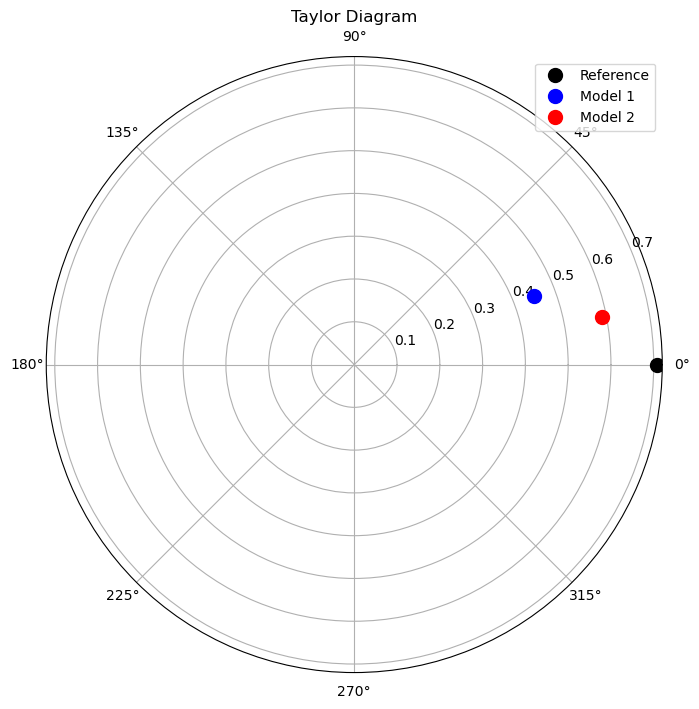

In [156]:
# Chat GPT test

import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
reference = np.array([0.5, 1.0, 1.5, 2.0, 2.5])
model1 = reference + np.random.rand(5)  # Simulated model 1
model2 = reference + np.random.rand(5)  # Simulated model 2

# Calculate statistics for the Taylor diagram
std_reference = np.std(reference)
std_model1 = np.std(model1)
std_model2 = np.std(model2)
corr_model1 = np.corrcoef(reference, model1)[0, 1]
corr_model2 = np.corrcoef(reference, model2)[0, 1]

# Create the Taylor diagram
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')

# Plot reference point
ax.plot(0, std_reference, 'ko', markersize=10, label='Reference')

# Plot model 1
ax.plot(np.arccos(corr_model1), std_model1, 'bo', markersize=10, label='Model 1')

# Plot model 2
ax.plot(np.arccos(corr_model2), std_model2, 'ro', markersize=10, label='Model 2')

# Add gridlines
ax.grid(True)

# Set the title and legend
ax.set_title('Taylor Diagram')
ax.legend()

# Show the plot
plt.show()

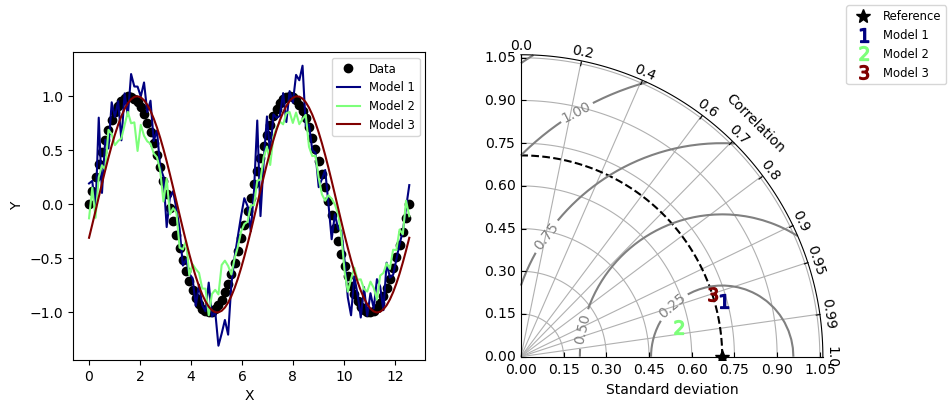

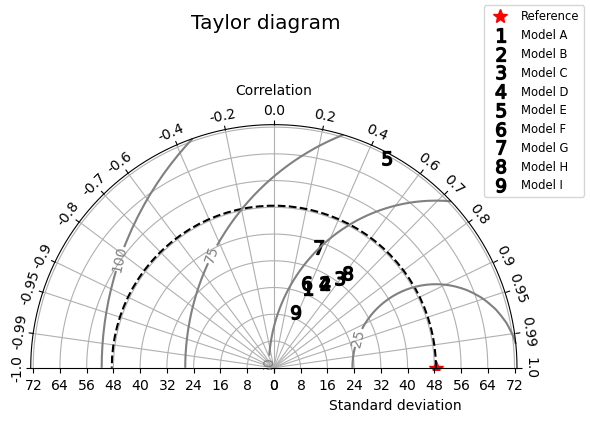

In [3]:
# found online
#!/usr/bin/env python
# Copyright: This document has been placed in the public domain.

"""
Taylor diagram (Taylor, 2001) implementation.
Note: If you have found these software useful for your research, I would
appreciate an acknowledgment.
"""

__version__ = "Time-stamp: <2018-12-06 11:43:41 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

import numpy as NP
import matplotlib.pyplot as PLT


class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


def test1():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset
    x = NP.linspace(0, 4*NP.pi, 100)
    data = NP.sin(x)
    refstd = data.std(ddof=1)           # Reference standard deviation

    # Generate models
    m1 = data + 0.2*NP.random.randn(len(x))     # Model 1
    m2 = 0.8*data + .1*NP.random.randn(len(x))  # Model 2
    m3 = NP.sin(x-NP.pi/10)                     # Model 3

    # Compute stddev and correlation coefficient of models
    samples = NP.array([ [m.std(ddof=1), NP.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3)])

    fig = PLT.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(1, 2, 1, xlabel='X', ylabel='Y')
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="Reference",
                        srange=(0, 1.5))

    colors = PLT.matplotlib.cm.jet(NP.linspace(0, 1, len(samples)))

    ax1.plot(x, data, 'ko', label='Data')
    for i, m in enumerate([m1, m2, m3]):
        ax1.plot(x, m, c=colors[i], label='Model %d' % (i+1))
    ax1.legend(numpoints=1, prop=dict(size='small'), loc='best')

    # Add the models to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label="Model %d" % (i+1))

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


def test2():
    """
    Climatology-oriented example (after iteration w/ Michael A. Rawlins).
    """

    # Reference std
    stdref = 48.491

    # Samples std,rho,name
    samples = [[25.939, 0.385, "Model A"],
               [29.593, 0.509, "Model B"],
               [33.125, 0.585, "Model C"],
               [29.593, 0.509, "Model D"],
               [71.215, 0.473, "Model E"],
               [27.062, 0.360, "Model F"],
               [38.449, 0.342, "Model G"],
               [35.807, 0.609, "Model H"],
               [17.831, 0.360, "Model I"]]

    fig = PLT.figure()

    dia = TaylorDiagram(stdref, fig=fig, label='Reference', extend=True)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc='k', mec='k',
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')
    fig.suptitle("Taylor diagram", size='x-large')  # Figure title

    return dia


if __name__ == '__main__':

    dia = test1()
    dia = test2()

    PLT.show()

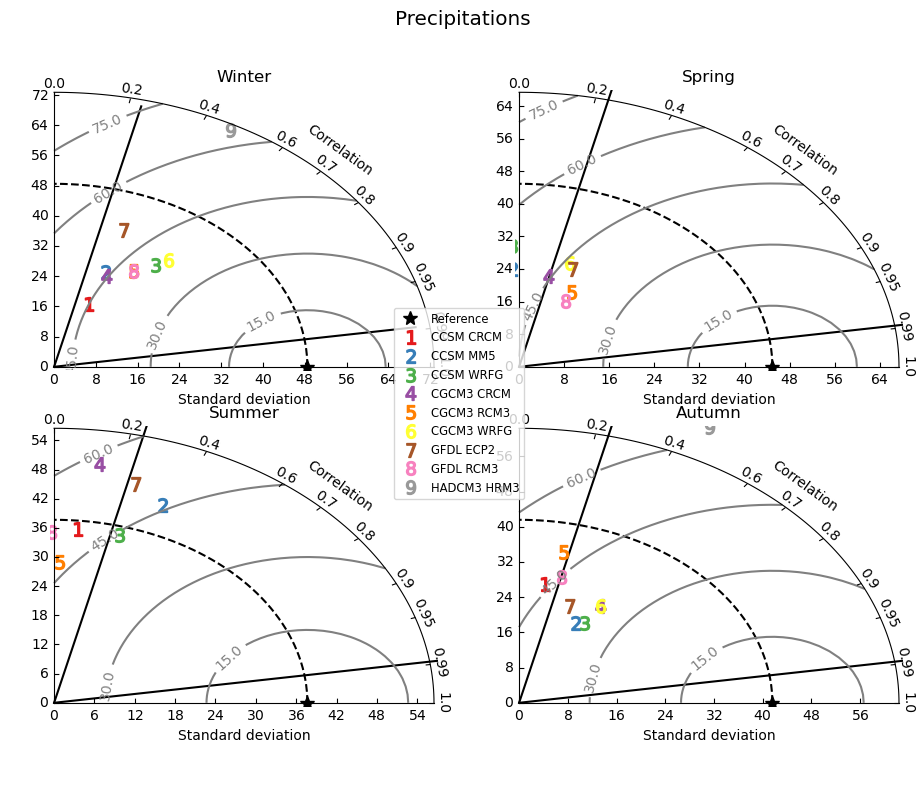

In [161]:
#!/usr/bin/env python

__version__ = "Time-stamp: <2018-12-06 11:55:22 ycopin>"
__author__ = "Yannick Copin <yannick.copin@laposte.net>"

"""
Example of use of TaylorDiagram. Illustration dataset courtesy of Michael
Rawlins.
Rawlins, M. A., R. S. Bradley, H. F. Diaz, 2012. Assessment of regional climate
model simulation estimates over the Northeast United States, Journal of
Geophysical Research (2012JGRD..11723112R).
"""

import numpy as NP
import matplotlib.pyplot as PLT

# Reference std
stdrefs = dict(winter=48.491,
               spring=44.927,
               summer=37.664,
               autumn=41.589)

# Sample std,rho: Be sure to check order and that correct numbers are placed!
samples = dict(winter=[[17.831, 0.360, "CCSM CRCM"],
                       [27.062, 0.360, "CCSM MM5"],
                       [33.125, 0.585, "CCSM WRFG"],
                       [25.939, 0.385, "CGCM3 CRCM"],
                       [29.593, 0.509, "CGCM3 RCM3"],
                       [35.807, 0.609, "CGCM3 WRFG"],
                       [38.449, 0.342, "GFDL ECP2"],
                       [29.593, 0.509, "GFDL RCM3"],
                       [71.215, 0.473, "HADCM3 HRM3"]],
               spring=[[32.174, -0.262, "CCSM CRCM"],
                       [24.042, -0.055, "CCSM MM5"],
                       [29.647, -0.040, "CCSM WRFG"],
                       [22.820, 0.222, "CGCM3 CRCM"],
                       [20.505, 0.445, "CGCM3 RCM3"],
                       [26.917, 0.332, "CGCM3 WRFG"],
                       [25.776, 0.366, "GFDL ECP2"],
                       [18.018, 0.452, "GFDL RCM3"],
                       [79.875, 0.447, "HADCM3 HRM3"]],
               summer=[[35.863, 0.096, "CCSM CRCM"],
                       [43.771, 0.367, "CCSM MM5"],
                       [35.890, 0.267, "CCSM WRFG"],
                       [49.658, 0.134, "CGCM3 CRCM"],
                       [28.972, 0.027, "CGCM3 RCM3"],
                       [60.396, 0.191, "CGCM3 WRFG"],
                       [46.529, 0.258, "GFDL ECP2"],
                       [35.230, -0.014, "GFDL RCM3"],
                       [87.562, 0.503, "HADCM3 HRM3"]],
               autumn=[[27.374, 0.150, "CCSM CRCM"],
                       [20.270, 0.451, "CCSM MM5"],
                       [21.070, 0.505, "CCSM WRFG"],
                       [25.666, 0.517, "CGCM3 CRCM"],
                       [35.073, 0.205, "CGCM3 RCM3"],
                       [25.666, 0.517, "CGCM3 WRFG"],
                       [23.409, 0.353, "GFDL ECP2"],
                       [29.367, 0.235, "GFDL RCM3"],
                       [70.065, 0.444, "HADCM3 HRM3"]])

# Colormap (see http://www.scipy.org/Cookbook/Matplotlib/Show_colormaps)
colors = PLT.matplotlib.cm.Set1(NP.linspace(0,1,len(samples['winter'])))

# Here set placement of the points marking 95th and 99th significance
# levels. For more than 102 samples (degrees freedom > 100), critical
# correlation levels are 0.195 and 0.254 for 95th and 99th
# significance levels respectively. Set these by eyeball using the
# standard deviation x and y axis.

#x95 = [0.01, 0.68] # For Tair, this is for 95th level (r = 0.195)
#y95 = [0.0, 3.45]
#x99 = [0.01, 0.95] # For Tair, this is for 99th level (r = 0.254)
#y99 = [0.0, 3.45]

x95 = [0.05, 13.9] # For Prcp, this is for 95th level (r = 0.195)
y95 = [0.0, 71.0]
x99 = [0.05, 19.0] # For Prcp, this is for 99th level (r = 0.254)
y99 = [0.0, 70.0]

rects = dict(winter=221,
             spring=222,
             summer=223,
             autumn=224)

fig = PLT.figure(figsize=(11,8))
fig.suptitle("Precipitations", size='x-large')

for season in ['winter','spring','summer','autumn']:

    dia = TaylorDiagram(stdrefs[season], fig=fig, rect=rects[season],
                        label='Reference')

    dia.ax.plot(x95,y95,color='k')
    dia.ax.plot(x99,y99,color='k')

    # Add samples to Taylor diagram
    for i,(stddev,corrcoef,name) in enumerate(samples[season]):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       #mfc='k', mec='k', # B&W
                       mfc=colors[i], mec=colors[i], # Colors
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5') # 5 levels
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    # Tricky: ax is the polar ax (used for plots), _ax is the
    # container (used for layout)
    dia._ax.set_title(season.capitalize())

# Add a figure legend and title. For loc option, place x,y tuple inside [ ].
# Can also use special options here:
# http://matplotlib.sourceforge.net/users/legend_guide.html

fig.legend(dia.samplePoints,
           [ p.get_label() for p in dia.samplePoints ],
           numpoints=1, prop=dict(size='small'), loc='center')

fig.tight_layout()

PLT.savefig('test_taylor_4panel.png')
PLT.show()


In [ ]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} numpy

In [ ]:
conda create -n cdat -c conda-forge -c cdat vcs

In [ ]:
import scipy as sp
import scipy.stats